In [3]:
import pandas as pd, numpy as np
from fidap import fidap_client
import config

In [7]:
fidap = fidap_client(db='sf_gcp', api_key=config.FIDAP_API_KEY)

Let's first explore the data and find some basic numbers here.

In [10]:
df2 = fidap.sql("""
    select "insider_trades"."ticker", "insider_trades"."filingdate", "insider_trades"."transactionshares",
    "insider_trades"."transactionvalue", "daily"."open", "daily"."close", "daily"."volume", "daily"."pc_1d", "daily"."pc_1w", "daily"."pc_1m", "daily"."fc_1d", "daily"."fc_1w", "daily"."fc_1m","daily"."marketcap"
    from "FIDAP_DATA_SOURCES"."FIDAP_SCHEMA"."insider_trades" AS "insider_trades", "FIDAP_DATA_SOURCES"."FIDAP_SCHEMA"."tickers" AS "tickers", "FIDAP_DATA_SOURCES"."FIDAP_SCHEMA"."daily" AS "daily"
    where 
    "insider_trades"."ticker" = "tickers"."ticker" and 
    "insider_trades"."ticker" = "daily"."ticker" and
    "insider_trades"."filingdate" = "daily"."date" and
    "insider_trades"."transactionvalue" > 100000 and 
    "insider_trades"."securitytitle" = 'Common Stock' ORDER BY "insider_trades"."filingdate" DESC;
""")

In [11]:
ticker = "AAPL"

In [12]:
df2.head()

,ticker,filingdate,transactionshares,transactionvalue,open,close,volume,pc_1d,pc_1w,pc_1m,fc_1d,fc_1w,fc_1m,marketcap
0,FL,2021-03-26,-2136,114511,57.31,57.57,1044170.0,0.025289,-0.016570,0.051507,-0.028140,NaN,NaN,5.945700e+09
1,REGI,2021-03-26,-3090,196030,65.50,63.78,2246533.0,0.005359,-0.054270,-0.322138,-0.054249,NaN,NaN,2.508800e+09
2,ORIC,2021-03-26,-27816,664246,24.68,23.75,269369.0,-0.025841,-0.102079,-0.317136,0.000842,NaN,NaN,8.715000e+08
3,ORIC,2021-03-26,-51523,1272618,24.68,23.75,269369.0,-0.025841,-0.102079,-0.317136,0.000842,NaN,NaN,8.715000e+08
4,SELF,2021-03-26,24100,108691,4.55,4.72,13202.0,0.046563,0.004255,0.053571,-0.004237,NaN,NaN,4.420000e+07


In [13]:
len(df2)

295012

In [14]:
df2['mc_pct'] = df2['transactionvalue'] / (df2['marketcap']*1e6)

In [15]:
df2['sale'] = np.where(df2['transactionshares'] > 0, False, True)

In [16]:
df2

,ticker,filingdate,transactionshares,transactionvalue,open,close,volume,pc_1d,pc_1w,pc_1m,fc_1d,fc_1w,fc_1m,marketcap,mc_pct,sale
0,FL,2021-03-26,-2136,114511,57.31,57.57,1044170.0,0.025289,-0.016570,0.051507,-0.028140,NaN,NaN,5.945700e+09,1.925946e-11,True
1,REGI,2021-03-26,-3090,196030,65.50,63.78,2246533.0,0.005359,-0.054270,-0.322138,-0.054249,NaN,NaN,2.508800e+09,7.813696e-11,True
2,ORIC,2021-03-26,-27816,664246,24.68,23.75,269369.0,-0.025841,-0.102079,-0.317136,0.000842,NaN,NaN,8.715000e+08,7.621870e-10,True
3,ORIC,2021-03-26,-51523,1272618,24.68,23.75,269369.0,-0.025841,-0.102079,-0.317136,0.000842,NaN,NaN,8.715000e+08,1.460262e-09,True
4,SELF,2021-03-26,24100,108691,4.55,4.72,13202.0,0.046563,0.004255,0.053571,-0.004237,NaN,NaN,4.420000e+07,2.459072e-09,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295007,EBS,2016-01-04,21600,182088,39.21,38.09,437730.0,NaN,NaN,NaN,0.013127,-0.097663,-0.032029,1.483300e+09,1.227587e-10,False
295008,EBS,2016-01-04,-21600,864000,39.21,38.09,437730.0,NaN,NaN,NaN,0.013127,-0.097663,-0.032029,1.483300e+09,5.824850e-10,True
295009,PRO,2016-01-04,-4898,112850,22.54,22.20,302975.0,NaN,NaN,NaN,-0.010360,-0.114414,-0.468919,6.593000e+08,1.711664e-10,True
295010,PRO,2016-01-04,11675,268992,22.54,22.20,302975.0,NaN,NaN,NaN,-0.010360,-0.114414,-0.468919,6.593000e+08,4.079964e-10,False


In [17]:
df2 = df2.dropna()

In [18]:
features = ['close', 'marketcap', 'mc_pct', 'sale']
label = 'fc_1m'

In [19]:
import xgboost as xgb

In [20]:
model = xgb.XGBRegressor()

In [21]:
model.fit(df2[features],df2[label])

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [22]:
preds = model.predict(df2[features])

In [23]:
df2['predict'] = preds

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [24]:
df2

,ticker,filingdate,transactionshares,transactionvalue,open,close,volume,pc_1d,pc_1w,pc_1m,fc_1d,fc_1w,fc_1m,marketcap,mc_pct,sale,predict
9676,SNA,2021-02-25,7500,1208850,206.75,204.07,529270.0,-0.013297,0.065250,0.138339,-0.004704,0.033371,0.116774,1.106120e+10,1.092874e-10,False,0.034938
9677,FTNT,2021-02-25,-1000,165300,168.82,168.00,2260394.0,-0.010892,0.001849,0.106574,0.005060,-0.024226,0.093274,2.741610e+10,6.029304e-12,True,-0.003768
9678,SNA,2021-02-25,9000,1242270,206.75,204.07,529270.0,-0.013297,0.065250,0.138339,-0.004704,0.033371,0.116774,1.106120e+10,1.123088e-10,False,0.034938
9679,FORR,2021-02-25,3869,148454,45.00,45.48,32823.0,0.008873,0.057429,0.082084,-0.006596,-0.010334,-0.055409,8.625000e+08,1.721206e-10,False,0.025596
9680,TRUP,2021-02-25,-5000,510850,101.11,94.72,368331.0,-0.071373,-0.088266,-0.196471,0.021537,-0.091744,-0.223395,3.739000e+09,1.366274e-10,True,0.010093
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
291771,VRTX,2016-02-04,-3700,336737,93.49,91.72,2452985.0,-0.023008,-0.011212,-0.253641,-0.055713,-0.130942,-0.052442,2.253720e+10,1.494139e-11,True,0.007206
291772,INGR,2016-02-04,-1530,152939,100.06,99.19,571303.0,-0.010574,0.023105,0.068858,0.011695,-0.007763,0.061095,7.096500e+09,2.155133e-11,True,0.008486
291773,WRK,2016-02-04,8995,300073,33.13,34.43,3319042.0,0.033624,0.087836,-0.243629,-0.029916,-0.130410,0.027011,8.852400e+09,3.389736e-11,False,0.017648
291774,WRK,2016-02-04,3900,130104,33.13,34.43,3319042.0,0.033624,0.087836,-0.243629,-0.029916,-0.130410,0.027011,8.852400e+09,1.469703e-11,False,0.017648


In [25]:
df2[df2['predict'] > 0]['fc_1m'].mean()

0.027069860901369116

In [26]:
df2[df2['predict'] < 0]['fc_1m'].mean()

-0.05169097847122688

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

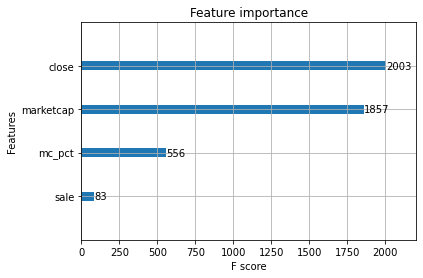

In [27]:
xgb.plot_importance(model)


# Predicting the future price using regression

### Reading in Data from Fidap

In [49]:
import pandas as pd, numpy as np
from fidap import fidap_client
import config
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing, linear_model
fidap = fidap_client(db='sf_gcp', api_key=config.FIDAP_API_KEY)

In [50]:
trading_data = fidap.sql("""
    select "insider_trades"."ticker", "insider_trades"."filingdate", "insider_trades"."transactionshares",
    "insider_trades"."transactionvalue", "daily"."open", "daily"."close", "daily"."volume", "daily"."pc_1d", "daily"."pc_1w", "daily"."pc_1m", "daily"."fc_1d", "daily"."fc_1w", "daily"."fc_1m","daily"."marketcap"
    from "FIDAP_DATA_SOURCES"."FIDAP_SCHEMA"."insider_trades" AS "insider_trades", "FIDAP_DATA_SOURCES"."FIDAP_SCHEMA"."tickers" AS "tickers", "FIDAP_DATA_SOURCES"."FIDAP_SCHEMA"."daily" AS "daily"
    where 
    "insider_trades"."ticker" = "tickers"."ticker" and 
    "insider_trades"."ticker" = "daily"."ticker" and
    "insider_trades"."filingdate" = "daily"."date" and
    "insider_trades"."transactionvalue" > 100000 and 
    "insider_trades"."securitytitle" = 'Common Stock' ORDER BY "insider_trades"."filingdate" DESC;
""")

In [51]:
trading_data.shape

(295012, 14)

## Split the Data into Train and Test (3:1)

In [52]:
trading_data.dropna(inplace=True)

In [53]:
trading_data = trading_data[trading_data.fc_1m < 1]

In [54]:
train_df, test_df = trading_data.iloc[:176813], trading_data.iloc[176813:]

In [55]:
# Describe data to see what kind of limits and bounds they have. Also determine statistical measures
train_df.describe()

,transactionshares,transactionvalue,open,close,volume,pc_1d,pc_1w,pc_1m,fc_1d,fc_1w,fc_1m,marketcap
count,1.768130e+05,1.768130e+05,176813.000000,176813.000000,1.768130e+05,176813.000000,176813.000000,176813.000000,176813.000000,176813.000000,176813.000000,1.768130e+05
mean,-1.464831e+04,2.728229e+06,101.345676,101.336850,2.879629e+06,0.000810,0.014831,0.059850,0.000461,0.001330,0.005236,2.787339e+10
std,2.334148e+06,5.013485e+07,119.911777,119.757106,8.627313e+06,0.040653,0.121088,0.248344,0.036233,0.074068,0.149865,7.579167e+10
min,-1.440000e+08,1.000010e+05,0.020000,0.020000,0.000000e+00,-0.820556,-0.963727,-0.970515,-0.652326,-0.777778,-0.830523,4.000000e+05
25%,-1.080400e+04,1.800000e+05,32.090000,32.110000,3.363840e+05,-0.011583,-0.020679,-0.027318,-0.012464,-0.027717,-0.058098,1.970600e+09
50%,-3.392000e+03,3.528390e+05,64.950000,64.950000,8.468880e+05,0.000614,0.010246,0.041536,0.000033,0.002137,0.008197,6.021900e+09
75%,1.553000e+03,8.636970e+05,126.520000,126.410000,2.229971e+06,0.013131,0.043003,0.117480,0.012749,0.030612,0.071201,2.180510e+10
max,7.025000e+08,8.917183e+09,2408.000000,2280.000000,4.010487e+08,4.800000,15.909621,23.786325,3.310861,1.695652,0.998261,2.248598e+12


In [56]:
train_df = train_df[train_df.fc_1m < 1]

In [57]:
# Do some data transformations and create some more columns
def create_features(data: pd.DataFrame):
    data_ = data.copy(deep=True)
    data_['mc_pct'] = data_['transactionvalue'] / data_['marketcap']
    data_['sale'] = np.where(data_['transactionshares'] > 0, 0, 1)
    return data_

In [58]:
train_df_mod = create_features(train_df)
test_df_mod = create_features(test_df)

In [59]:
train_df_mod.head()

,ticker,filingdate,transactionshares,transactionvalue,open,close,volume,pc_1d,pc_1w,pc_1m,fc_1d,fc_1w,fc_1m,marketcap,mc_pct,sale
9676,SNA,2021-02-25,7500,1208850,206.75,204.07,529270.0,-0.013297,0.065250,0.138339,-0.004704,0.033371,0.116774,1.106120e+10,0.000109,0
9677,FTNT,2021-02-25,-1000,165300,168.82,168.00,2260394.0,-0.010892,0.001849,0.106574,0.005060,-0.024226,0.093274,2.741610e+10,0.000006,1
9678,SNA,2021-02-25,9000,1242270,206.75,204.07,529270.0,-0.013297,0.065250,0.138339,-0.004704,0.033371,0.116774,1.106120e+10,0.000112,0
9679,FORR,2021-02-25,3869,148454,45.00,45.48,32823.0,0.008873,0.057429,0.082084,-0.006596,-0.010334,-0.055409,8.625000e+08,0.000172,0
9680,TRUP,2021-02-25,-5000,510850,101.11,94.72,368331.0,-0.071373,-0.088266,-0.196471,0.021537,-0.091744,-0.223395,3.739000e+09,0.000137,1


<AxesSubplot:>

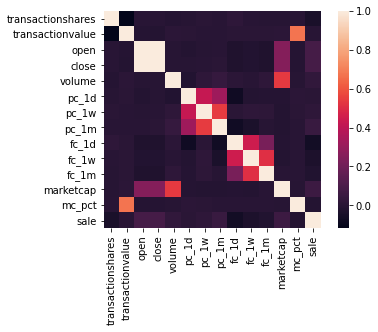

In [60]:
# check correlation between values in df
insider_trading_corr = train_df_mod.corr()
sns.heatmap(insider_trading_corr,square=True)

<AxesSubplot:xlabel='fc_1m', ylabel='Count'>

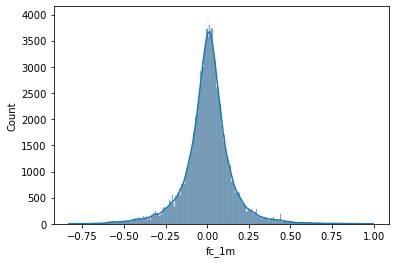

In [61]:
# From the above the fields are still correlated to the fc_1m, we will look at the fc_1m distribution
sns.histplot(train_df_mod['fc_1m'], kde=True)

In [62]:
features = ['ticker', 'sale', 'transactionshares', 'transactionvalue', 'close', 'marketcap', 'mc_pct']
labels = ['fc_1m']
insider_trading_train_features = train_df_mod[features].copy(deep=True)
insider_trading_train_labels = np.array(train_df_mod[labels])
insider_trading_test_features = test_df_mod[features].copy(deep=True)

In [63]:
encoder = preprocessing.OrdinalEncoder()
train_ticker = encoder.fit_transform(np.array(insider_trading_train_features['ticker']).reshape(-1, 1))
test_ticker = encoder.fit_transform(np.array(insider_trading_test_features['ticker']).reshape(-1, 1))

In [64]:
features[2:]

['transactionshares', 'transactionvalue', 'close', 'marketcap', 'mc_pct']

In [65]:
train_features_ = np.array(insider_trading_train_features[features[2:]])
test_features_ = np.array(insider_trading_test_features[features[2:]])
train_features = np.append(train_features_, train_ticker, axis=1)
test_features = np.append(test_features_, test_ticker, axis=1)

In [66]:
import numpy.random as nr
import sklearn.model_selection as ms
nr.seed(9988)
indx = range(train_features.shape[0])
indx = ms.train_test_split(indx, test_size = 0.3)
X_train = train_features[indx[0],:]
y_train = np.ravel(insider_trading_train_labels[indx[0]])
X_test = train_features[indx[1],:]
y_test = np.ravel(insider_trading_train_labels[indx[1]])

In [67]:
# Scale the numeric Features
scaler = preprocessing.StandardScaler().fit(X_train[:,2:])
X_train[:,2:] = scaler.transform(X_train[:,2:])
X_test[:,2:] = scaler.transform(X_test[:,2:])
test_features[:,2:] = scaler.transform(test_features[:,2:])

In [68]:
## define and fit the linear regression model
lin_mod = linear_model.LinearRegression(fit_intercept = False)
lin_mod.fit(X_train, y_train)

LinearRegression(fit_intercept=False)

In [69]:
import sklearn.metrics as sklm
import scipy.stats as ss
import math
def print_metrics(y_true, y_predicted, n_parameters):
    ## First compute R^2 and the adjusted R^2
    r2 = sklm.r2_score(y_true, y_predicted)
    r2_adj = r2 - (n_parameters - 1)/(y_true.shape[0] - n_parameters) * (1 - r2)
    
    ## Print the usual metrics and the R^2 values
    print('Mean Square Error      = ' + str(sklm.mean_squared_error(y_true, y_predicted)))
    print('Root Mean Square Error = ' + str(math.sqrt(sklm.mean_squared_error(y_true, y_predicted))))
    print('Mean Absolute Error    = ' + str(sklm.mean_absolute_error(y_true, y_predicted)))
    print('Median Absolute Error  = ' + str(sklm.median_absolute_error(y_true, y_predicted)))
    print('R^2                    = ' + str(r2))
    print('Adjusted R^2           = ' + str(r2_adj))
   
y_score = lin_mod.predict(X_test) 
print_metrics(y_test, y_score, 28)

Mean Square Error      = 0.022872762211283797
Root Mean Square Error = 0.15123743654030836
Mean Absolute Error    = 0.1014536950410061
Median Absolute Error  = 0.06601706941792465
R^2                    = -0.0007916232499338705
Adjusted R^2           = -0.0013013066252875035


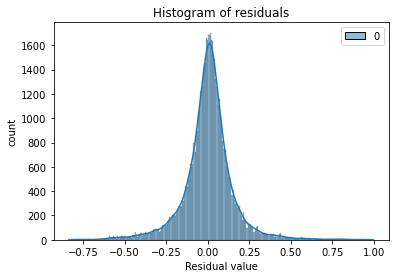

In [70]:
# Evaluate Residuals
def hist_resids(y_test, y_score):
    ## first compute vector of residuals. 
    resids = np.subtract(y_test.reshape(-1,1), y_score.reshape(-1,1))
    ## now make the residual plots
    sns.histplot(resids, kde=True)
    plt.title('Histogram of residuals')
    plt.xlabel('Residual value')
    plt.ylabel('count')
    
hist_resids(y_test, y_score)

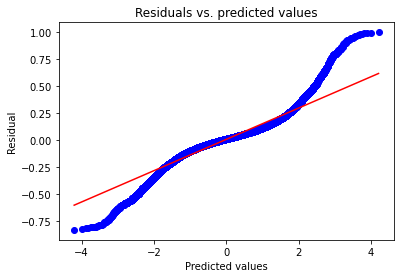

In [71]:
def resid_qq(y_test, y_score):
    ## first compute vector of residuals. 
    resids = np.subtract(y_test.reshape(-1,1), y_score.reshape(-1,1))
    ## now make the residual plots
    ss.probplot(resids.flatten(), plot = plt)
    plt.title('Residuals vs. predicted values')
    plt.xlabel('Predicted values')
    plt.ylabel('Residual')
    
resid_qq(y_test, y_score)

In [72]:
# Try XGBoost
import xgboost as xg

In [73]:
xgb_r = xg.XGBRegressor(objective ='reg:squarederror', 
                  n_estimators = 20, seed = 123) 
  
# Fitting the model 
xgb_r.fit(X_train, y_train) 
  
# Predict the model 
y_score = xgb_r.predict(X_test)

In [74]:
print_metrics(y_test, y_score, 28)

Mean Square Error      = 0.020865019771848358
Root Mean Square Error = 0.14444729063519454
Mean Absolute Error    = 0.09767451269139285
Median Absolute Error  = 0.06408230040814819
R^2                    = 0.0870566128515683
Adjusted R^2           = 0.08659166884498523
